# Active Learning with Multiple Data Annotators via CROWDLAB

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cleanlab/examples/blob/master/active_learning_multiannotator/active_learning.ipynb)

This notebook demonstrates a practical approach to active learning for training classification models with cleanlab. In active learning, we aim to construct a labeled dataset by collecting the fewest labels that still allow us to train an accurate classifier model. Here we assume data labeling is done in **batches**, and between these data labeling rounds, we retrain our classifier and combine it with CROWDLAB to decide what examples (i.e. datapoints) to label next round. We assume there are **multiple** annotators to label the data, but since their labels are not necessarily perfect, we sometimes wish to ask a new annotator to provide an extra label for a previously labeled example. This active learning with multiple annotators setup is more widely applicable than academic studies which only consider labeling one example in each round or being limited to a single (noise-free) annotation per example.

cleanlab provides two useful estimates for multi-annotator active learning: (1) an active learning score quantifying how desirable it is to collect an additional label for every possible example, (2) accurate consensus labels for the previously labeled examples  that can be used for classifier model training.

This notebook demonstrates how to compute these easily for use in sequential active learning, showing how a classification model iteratively improves after (re)labeling examples for multiple rounds. Some examples in the dataset will have been labeled by multiple annotators, and not all examples have to have been labeled at the beginning. cleanlab's active learning score indicates if you should collect more labels for an already-labeled example (thus having a larger number of annotators label a potentially difficult example), or get a label for a potentially informative example that has not yet been labeled.

This notebook implements the following steps:

1. Establish consensus labels (for the already labeled data). Use them to train a classifier model and then obtain out-of-sample predicted probabilities for each example.
2. Compute active learning scores for every example, which estimate our current confidence in knowing its true label.
3. Collect additional labels for the examples with the lowest active learning scores. These are the most potentially informative examples whose true label we are least certain of. 
4. Repeat the steps above to collect as many labels as your budget permits.

The accuracy of the model trained on the resulting dataset will generally match that of the same model trained on a much larger set of randomly collected labels. I.e. this is the most cost-effective way to train an accurate classifier!

In this example we use a modified version of the [Wall-Following Robot Navigation](https://www.openml.org/search?type=data&sort=runs&status=any&qualities.NumberOfClasses=gte_2&qualities.NumberOfInstances=between_1000_10000&id=1526) dataset, with multiple data annotators who each provide noisy labels.

## Import dependencies and get data

Please install the dependencies specified in this [requirements.txt](https://github.com/cleanlab/examples/blob/master/active_learning_multiannotator/requirements.txt) file before running the notebook.  

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

from cleanlab.multiannotator import get_majority_vote_label, get_label_quality_multiannotator, get_active_learning_scores

from utils.model_training import fit_predict_proba
from utils.active_learning import setup_next_iter_data, add_new_annotator


In [2]:
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/ActiveLearning/WallRobot/data.tar.gz'
!tar -xf data.tar.gz data/

File ‘data.tar.gz’ already there; not retrieving.



We load the following datafiles:

- `multiannotator_labels` is a DataFrame that contains labels from multiple annotators for each example (different number of annotations per example)
- `X_labeled` are the features for the examples that have been labeled by at least one annotator
- `X_unlabeled` are the features for the examples that have not yet been labeled by any annotator

Additionally, we load some extra files for demo purposes, which will probably not be available in your application:

- `extra_labels_labeled` and `extra_labels_unlabeled` are sampled from when we get ask annotators to provide additional labels later in this notebook
- `X_test` and `true_labels_test` are used to measure the current model's predictive accuracy in each round of multi-annotator active learning

In [3]:
multiannotator_labels = pd.DataFrame(np.load("data/multiannotator_labels_labeled.npy"))

X_labeled = np.load("data/X_labeled.npy")
X_unlabeled = np.load("data/X_unlabeled.npy")

extra_labels_labeled = np.load("data/extra_labels_labeled.npy")
extra_labels_unlabeled = np.load("data/extra_labels_unlabeled.npy")

X_test = np.load("data/X_test.npy")
true_labels_test = np.load("data/true_labels_test.npy")


## Train model to obtain predicted probabilites

First, we train our model on a set of consensus labels obtained using majority vote to get the out-of-sample predicted class probabilities for both the labeled and unlabeled data. 

The function will return two sets of predicted probabilites, `pred_probs_labeled` are the predicted probabilites for examples that have existing annotator labels (they correspond directly with the features `X_labeled`), whereas `active_learning_scores_unlabeled` are the predicted probabilites for examples that do not have any annotator labels (they correspond directly with the features `X_unlabeled`). These predicted probabilities will later be used to compute the active learning score.

If working with your own dataset, you should consider modifying this `fit_predict_proba` function so that it is better fitted for training your specific dataset.

In [4]:
# get current consensus labels
consensus_labels = get_majority_vote_label(multiannotator_labels)

# train model to get out-of-sample predicted probabilies for both labels and unlabeled data
pred_probs_labeled, pred_probs_unlabeled = fit_predict_proba(
    ExtraTreesClassifier(),
    X_labeled,
    consensus_labels,
    cv_n_folds=5,
    X_unlabeled=X_unlabeled,
)


## Obtain active learning scores

Next, we will get the active learning scores for each datapoint (both labeled and unlabeled) by using a combination of the annotators' agremeent and model confidence. These scores represent how confident we are about an example's true label based on the currently obtained annotations; examples with the lowest scores are those for which additional labels should be collected (i.e. likely the most informative). These scores are estimated via an **Active CROWDLAB** algorithm developed by the Cleanlab team, and may sometimes prioritize an already-labeled example over an unlabeled example if the annotations for the labeled example are deemed unreliable (Active CROWDLAB appropriately estimates the value of collecting new annotations for unlabeled data vs already-labeled data). 

Similar to above, `active_learning_scores` represents the scores for examples with existing annotator labels, and `active_learning_scores_unlabeled` represents the scores for examples with no annotator labels.

In [5]:
active_learning_scores, active_learning_scores_unlabeled = get_active_learning_scores(
    multiannotator_labels, pred_probs_labeled, pred_probs_unlabeled
)

In [6]:
# sample of active learning scores
active_learning_scores[:5]

array([0.60722785, 0.74885414, 0.43063227, 0.5846288 , 0.5857348 ])

## Get index to relabel

Lastly, we can ranks the examples by their active learning scores, and obtain the index of the examples with the lowest scores; these are the least confident examples which we will want to collect more labels for.

The code cell below shows how to combine the labeled and unlabeled examples before ranking them and obtaining their respective indices to collect more labels.

In [7]:
batch_size_to_label = 100 # you can pick how many examples to collect more labels for at each round

num_labeled = len(active_learning_scores)
active_learning_scores_combined = np.concatenate((active_learning_scores, active_learning_scores_unlabeled))

to_label_idx_combined = np.argsort(active_learning_scores_combined)[:batch_size_to_label]
to_label_idx_labeled = to_label_idx_combined[to_label_idx_combined < num_labeled]
to_label_idx_unlabeled = (to_label_idx_combined[to_label_idx_combined >= num_labeled] - num_labeled)

In [8]:
# sample of indices to collect more labels for
to_label_idx_labeled

array([857, 910,  78,  94, 689, 860, 716, 612, 850, 382, 264, 507, 685,
       813, 148, 274, 575, 299,  87])

> ### Bringing Your Own Data (BYOD)?
> 
> You can easily replace the above with your own dataset, and obtain the active learning scores and indices to collect more labels for using the code above.
> 
> `multiannotator_labels` should be a numpy array of pandas DataFrame where each column represents an annotator and each row represents an examples. The classes should be ingeters from 0 to num_classes - 1, where examples that were not labeled by a particular annotator are represented using `np.nan`. `multiannotator_labels` should also only contain the examples that have been labeled by at least one annotator (no row should consist of only `np.nan` values).
> 
> `X_labeled` and `X_unlabeled` should be numpy arrays that have the same number of columns. However, if you do not have any unlabeled examples, you can also pass an empty array of `None` as the value of `X_unlabeled`.


## Improving model accuracy over 15 rounds of multi-annotator active learning (collecting new labels) 

The code below shows a full demonstration of how we can repeatedly use the functions demonstrated above for multiple rounds in order to select which examples to collect new labels for, ask annotators to provide these new labels (via a noisy simulation in this example), and use the newly collected labels to get improved consensus labels used to train an improved classification model.

This demonstration runs this multi-annotator active learning loop for 15 rounds, choosing 100 examples to collect more labels for each round. Each round, we use the consensus labels of each labeled example to train a classifier (here we used an `ExtraTrees` classifier) and obtain out-of-sample predicted probabilites, which is then used to compute the active learning scores for every example. We then synthetically collect new labels (this process is meant to simulate getting a new annotator to annotated a selection of examples) and repeat the active learning loop. 

For the first round of training, we obtain consensus labels using majority vote as we do not have any predicted probabilites yet. However for subsequent rounds we can leverage the predicted probabilites for each example obtained from the previous round to use cleanlab's [CROWDLAB algorithm](https://docs.cleanlab.ai/stable/tutorials/multiannotator.html) to obtain higher quality consensus labels for the model.

[Optional step] We also measure the model performance on a test set each round to demonstrate the improvement of the model.

In [9]:
num_rounds = 15
batch_size_to_label = 100

In [10]:
# function to get indices of examples with the lowest active learning score to collect more labels for
def get_idx_to_label(
    active_learning_scores,
    batch_size_to_label,
    active_learning_scores_unlabeled=None,
):
    if active_learning_scores_unlabeled is None:
        active_learning_scores_unlabeled = np.array([])

    num_labeled = len(active_learning_scores)
    active_learning_scores_combined = np.concatenate((active_learning_scores, active_learning_scores_unlabeled))

    if batch_size_to_label > len(active_learning_scores_combined):
        raise ValueError("num_examples_to_relabel is larger than the total number of examples available")

    to_label_idx_combined = np.argsort(active_learning_scores_combined)[:batch_size_to_label]
    to_label_idx = to_label_idx_combined[to_label_idx_combined < num_labeled]
    to_label_idx_unlabeled = (to_label_idx_combined[to_label_idx_combined >= num_labeled] - num_labeled)

    return to_label_idx, to_label_idx_unlabeled

In [11]:
model_accuacy_arr = np.full(num_rounds, np.nan)

for i in range(num_rounds):
    # get consensus labels
    if i == 0:
        consensus_labels = get_majority_vote_label(multiannotator_labels)
    else:
        # we can use the pred_probs from last round as the best model estimate
        results = get_label_quality_multiannotator(
            multiannotator_labels, 
            pred_probs_labeled,
            calibrate_probs=True,
        )
        consensus_labels = results["label_quality"]["consensus_label"]

    # train model to get out-of-sample predicted probabilites 
    pred_probs, pred_probs_unlabeled = fit_predict_proba(
        ExtraTreesClassifier(),
        X_labeled,
        consensus_labels,
        cv_n_folds=5,
        X_unlabeled=X_unlabeled,
    )

    # train a model on the full set of labeled data to evaluate model accuracy for the current round,
    # this is an optional step for demonstration purposes, in practical applications 
    # you may not have ground truth labels
    model = ExtraTreesClassifier()
    model.fit(X_labeled, consensus_labels)
    pred_labels = model.predict(X_test)
    model_accuacy_arr[i] = np.mean(pred_labels == true_labels_test)

    # compute active learning scores
    active_learning_scores, active_learning_scores_unlabeled = get_active_learning_scores(
        multiannotator_labels, pred_probs, pred_probs_unlabeled
    )

    # get the indices of examples to collect more labels for
    relabel_idx, relabel_idx_unlabeled = get_idx_to_label(
        active_learning_scores=active_learning_scores,
        active_learning_scores_unlabeled=active_learning_scores_unlabeled,
        batch_size_to_label=batch_size_to_label,
    )

    # format the data for the next round of active learning, ie. moving some unlabeled 
    # examples to the labeled pool because we are collecting labels for them
    (
        multiannotator_labels, relabel_idx_combined, X_labeled, X_unlabeled, pred_probs_labeled, 
        pred_probs_unlabeled, extra_labels_labeled, extra_labels_unlabeled,
    ) = setup_next_iter_data(
        multiannotator_labels, relabel_idx, relabel_idx_unlabeled, X_labeled, X_unlabeled, pred_probs, 
        pred_probs_unlabeled, extra_labels_labeled, extra_labels_unlabeled,
    )

    # add a new annotator that provides new labels for the examples with the lowest
    # active learning scores (indices obtained above)
    multiannotator_labels = add_new_annotator(
        multiannotator_labels, extra_labels_labeled, relabel_idx_combined
    )

Note that in the final step of the active learning loop above, we add one new annotator that annotates all the examples identified with the lowest active learning scores. However, it is not required that these examples be labeled by one new annotator (it is just done this way here for simplicity). These examples could instead be labeled by multiple new annotators, or multiple existing annotators, or any other combination. 

## Evaluate results

In [12]:
print(f"Initial model test accuracy: {model_accuacy_arr[0]:.3}")
print(f"Final model test accuracy (after 15 rounds of active learning): {model_accuacy_arr[-1]:.3}")

Initial model test accuracy: 0.902
Final model test accuracy (after 15 rounds of active learning): 0.982


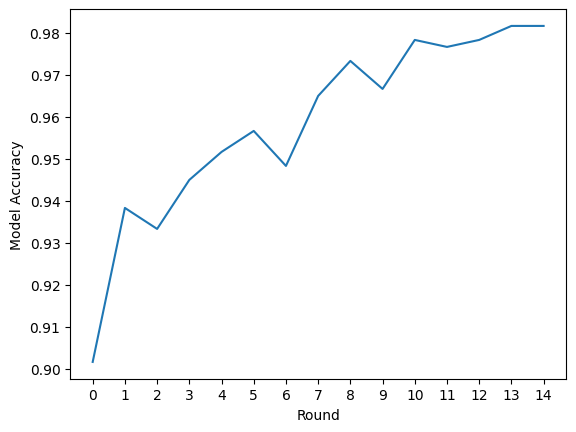

In [13]:
plt.plot(model_accuacy_arr)
plt.xticks(range(num_rounds))
plt.xlabel("Round")
plt.ylabel("Model Accuracy")
plt.show()

From the plot above, we can see that the model accuracy increases steadily with each additional round of collecting more labels, getting improved consensus labels, and model training.

## Other useful multiannotator statistics

After conducting multiple rounds of multi-annotator active learning, you can also estimate various statistics from the labeled data such as the higher quality [CROWDLAB consensus label](https://arxiv.org/abs/2210.06812) for each example, consensus label quality scores that quantify how likely each consensus label is correct, and annotator quality scores that quantify how noisy each annotator's labels are overall. 

Below we show how to obtain this information using the annotators' labels and the model's predicted class probabilites. Check out cleanlab's [multiannotator module](https://docs.cleanlab.ai/stable/tutorials/multiannotator.html) for details!

Using the annotator labels and predicted probabilites to get the consensus labels and other statistics:

In [14]:
multiannotator_results = get_label_quality_multiannotator(multiannotator_labels, pred_probs_labeled)

Each row of the `label_quality` dataframe corresponds to an example, here you can get the CROWDLAB consensus label and its quality score:

In [15]:
multiannotator_results["label_quality"].head()

,consensus_label,consensus_quality_score,annotator_agreement,num_annotations
0,0,0.891332,1.00,1
1,3,0.914493,1.00,1
2,1,0.349226,0.25,8
3,1,0.919139,1.00,1
4,1,0.837486,1.00,1


Each row of the `annotator_stats` dataframe corresponds to an annotator, here you can get their annotator quality and other information about the annotators:

In [16]:
multiannotator_results["annotator_stats"].head()

,annotator_quality,agreement_with_consensus,worst_class,num_examples_labeled
44,0.339440,0.49,3,100
42,0.401138,0.58,3,100
32,0.404506,0.47,3,100
33,0.433437,0.54,3,100
41,0.434918,0.62,3,100
